# Dependências

In [113]:
#Importando Bibliotecas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle
from dependencias.selecao_de_features import remover_colunas_constantes, chi_squared, \
                                             boruta_selector, variance_threshold_selector

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [114]:
#Constantes.
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_INTER_PATH = os.path.join('..','data','inter') 
DATA_INTER_TRAIN_NAME_1 = 'train_inter1.csv'
DATA_INTER_TRAIN_A1 = 'train_inter_a1.csv'
DATA_INTER_TRAIN_A2 = 'train_inter_a2.csv'
IMG_PATH = os.path.abspath(os.path.join('..','img'))
META_DATA_PATH_INTER = os.path.join(DATA_INTER_PATH,'dicionario_tipos_inter.pkl')

In [115]:
# Dados do dicionário salvo no pickle.
with open(META_DATA_PATH_INTER,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)
df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME_1), dtype=dicionario_tipo)

In [116]:
df_train.head()

,Department,Role,Will_Relocate,Trending Perf,Talent_Level,Percent_Remote,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,LinkedIn_Hits,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest),left_Company,EMP_Sat_OnPrem_mean,EMP_Sat_Remote_mean,EMP_Engagement_mean,Emp_Work_Status_mean,Emp_Competitive_mean,Emp_Collaborative_mean
0,Finance,Level 2-4,0,3,6,0.4,0.64,5,234,2,1,0,medium,44,1,1,1,2,2548,78,9,0,1.8,4.2,4.2,3.0,3.0,2.2
1,Warehouse,Level 2-4,0,3,6,0.8,0.82,5,265,5,0,0,medium,3,2,2,2,1,1514,85,7,1,3.5,4.2,1.8,2.8,3.0,2.8
2,Finance,Level 1,1,3,6,0.8,0.80,3,137,5,0,0,low,8,2,4,3,2,4980,70,7,0,3.5,4.2,4.2,3.5,2.4,3.2
3,Sales,Level 1,0,3,6,0.8,0.79,5,222,2,0,0,low,2,3,3,3,2,5953,78,9,0,3.5,4.2,4.2,4.0,2.4,2.8
4,Operations,Director,0,3,6,0.8,0.72,5,232,4,0,0,low,3,2,3,3,3,5447,80,4,0,3.5,4.2,4.2,2.0,2.8,3.0


# Seleção de Features

## Colunas constantes


In [117]:
#Verificando e dropando as colunas constantes.
df_train, const_cols = remover_colunas_constantes(df_train)

In [118]:
df_train.shape

(11999, 26)

## Colunas Variância aprox = 0

In [119]:
#Analisando com Variance Threshold.

In [120]:
#Utilizando apenas as variaveis numericas.
todas_as_variaveis = set(df_train.columns.tolist())
variaveis_categoricas = set(df_train.select_dtypes(include=['object']).columns.tolist())
variaveis_numericas = todas_as_variaveis - variaveis_categoricas
variaveis_numericas = list(variaveis_numericas) 

In [121]:
#DataFrame com os dados com variancia maior que 0,01.
df_train_variance_threshold = variance_threshold_selector(df_train.loc[:,variaveis_numericas], threshold=0.01)

In [122]:
df_train_categoricas = df_train.loc[:,variaveis_categoricas]

In [123]:
#Juntando os dados de variancia maior que 0,01 com outras features categoricas.
df_train = pd.concat([df_train_variance_threshold, df_train_categoricas],axis=1)

In [124]:
df_train.shape

(11999, 26)

In [147]:
# Tratando as variaveis categóricas para ordinais e variáveis numéricas para serem usadas na correlação.

#Convertento categórica para ordinal. 

#Variável Role

df_train_plot = df_train.replace(['Level 1','Level 2-4','Manager','Senior Manager','Director','Senior Director','VP'],[0,1,2,3,4,5,6])

#Variável Salary

df_train_plot = df_train.replace(['low','medium','high'], [0,1,2])

#Variável Work_accident
df_train_plot = df_train.replace(['0','1'],[0,1])

#VARIÁVEL TARGET - (LEFT_COMPANY) - DEMISSÃO.
df_train_plot = df_train.replace(['0','1'],[0,1])

In [148]:
#Trazendo as novas variaveis depois da conversão de categórica para ordinal.
todas_as_variaveis = set(df_train.columns.tolist())
variaveis_categoricas_nominal_e_ordinal = set(df_train_plot.select_dtypes(include=['object']).columns.tolist())
variaveis_numericas = todas_as_variaveis - variaveis_categoricas_nominal_e_ordinal
variaveis_categoricas_nominal_e_ordinal = list(variaveis_categoricas)

# Primeira abordagem: Correlação + Chi2 + Boruta.

## Correlação

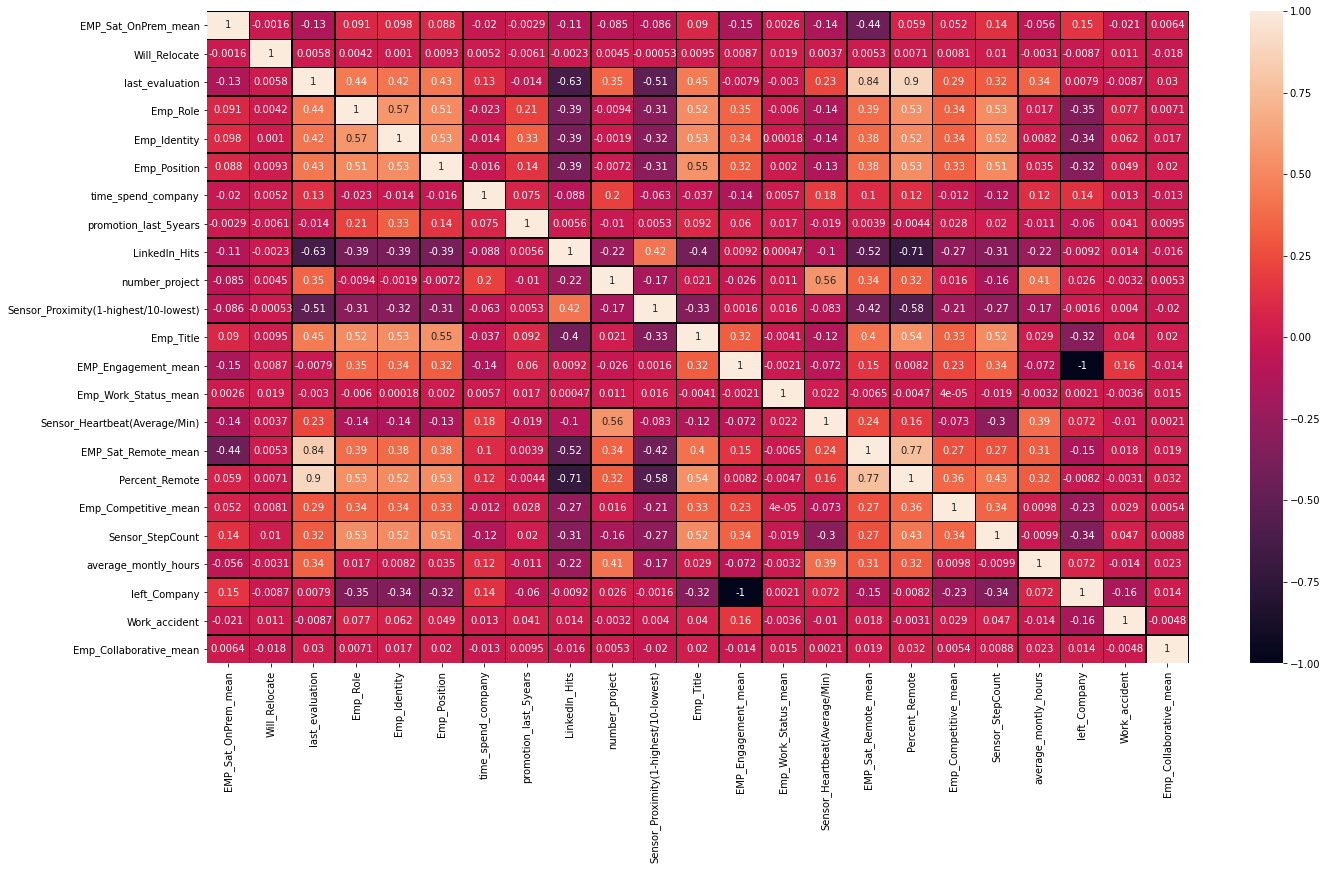

In [171]:
#Plot de correlação.

corr_matrix = df_train_plot.loc[:,variaveis_numericas].corr()
plt.subplots(figsize=(22, 12))
sns.heatmap(corr_matrix,
            linecolor='black',
            linewidths=.5,
            annot=True,
            annot_kws={"fontsize":10})
plt.savefig(os.path.join(IMG_PATH,'grafico_correlacao_pearson.png'), format='png')
plt.show()

In [150]:
#Filtros para Correlação em relação ao target.
lista_correlacao = corr_matrix['left_Company'].sort_values(axis=0,ascending=False).iloc[1:]
lista_correlacao = abs(lista_correlacao)

In [151]:
#Lista de Variáveis númericas descartadas com base na correlação.
lista_descart_corr = lista_correlacao[lista_correlacao < 0.01].index.tolist()

In [152]:
lista_descart_corr

['last_evaluation',
 'Emp_Work_Status_mean',
 'Sensor_Proximity(1-highest/10-lowest)',
 'Percent_Remote',
 'Will_Relocate',
 'LinkedIn_Hits']

## Chi2 

Será utilizado teste de Chi2 para verificar independências das variáveis categóricas nominal e ordinal 
em relação ao target 

In [153]:
chi2_df, logs = chi_squared(df_train_plot, y = 'left_Company', cols = variaveis_categoricas_nominal_e_ordinal)

In [154]:
chi2_df

,column,p-value,chi2_value
0,Department,9.509839e-01,1.134728
1,promotion_last_5years,7.894129e-11,42.283862
2,Role,3.417585e-01,6.779116
3,left_Company,NaN,NaN
4,salary,1.635328e-70,321.378227
5,Work_accident,6.107369e-66,294.179725


In [155]:
# Observando a mensagem. 
logs

['A coluna left_Company não pode ser avaliada. ']

 Como left Company é o próprio target, não calculamos o chi2 para ela.

Segundo o teste de hipotése realizado. 

Hipótese nula - H0: As variáveis são independentes.

As variáveis cujo p-valor < 0.05 tem relação com o target.

In [156]:
#As variáveis que serão excluídas. 
lista_descart_chi2 = chi2_df[chi2_df['p-value']>=0.05]['column'].tolist()

In [157]:
lista_descart_chi2

['Department', 'Role']

## Boruta

In [158]:
list_to_drop_boruta = boruta_selector(df_train_plot.drop(set(lista_descart_chi2 + lista_descart_corr),axis=1), y = 'left_Company')

In [159]:
list_to_drop_boruta

['Emp_Collaborative_mean', 'promotion_last_5years']

In [160]:
# Lendo os dados sem pre processamento
#df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME_1), dtype=dicionario_tipo)

In [161]:
lista_drop_abordagem_1 = set(lista_descart_chi2+lista_descart_corr+list_to_drop_boruta)


In [162]:
lista_drop_abordagem_1

{'Department',
 'Emp_Collaborative_mean',
 'Emp_Work_Status_mean',
 'LinkedIn_Hits',
 'Percent_Remote',
 'Role',
 'Sensor_Proximity(1-highest/10-lowest)',
 'Will_Relocate',
 'last_evaluation',
 'promotion_last_5years'}

In [143]:
lista_drop_abordagem_1

{'Department',
 'Emp_Collaborative_mean',
 'Emp_Work_Status_mean',
 'LinkedIn_Hits',
 'Percent_Remote',
 'Role',
 'Sensor_Proximity(1-highest/10-lowest)',
 'Will_Relocate',
 'last_evaluation',
 'promotion_last_5years'}

In [144]:
lista_descart_corr

['last_evaluation',
 'Emp_Work_Status_mean',
 'Sensor_Proximity(1-highest/10-lowest)',
 'Percent_Remote',
 'Will_Relocate',
 'LinkedIn_Hits']

In [145]:
lista_descart_chi2

['Department', 'Role']

In [163]:
lista_drop_abordagem_1 = set(lista_descart_chi2+lista_descart_corr+list_to_drop_boruta)


In [164]:
len(lista_drop_abordagem_1)

10

In [165]:
lista_drop_abordagem_1

{'Department',
 'Emp_Collaborative_mean',
 'Emp_Work_Status_mean',
 'LinkedIn_Hits',
 'Percent_Remote',
 'Role',
 'Sensor_Proximity(1-highest/10-lowest)',
 'Will_Relocate',
 'last_evaluation',
 'promotion_last_5years'}

In [166]:
# dropando as colunas pela abordagem 1
lista_drop_abordagem_1 = set(lista_descart_chi2+lista_descart_corr+list_to_drop_boruta)
df_train.drop(lista_drop_abordagem_1,axis=1).to_csv(os.path.join(DATA_INTER_PATH,DATA_INTER_TRAIN_A1), index=False)

Os primeiros metódos escolhidos para seleção de features são métodos simples(Correlação e Chi2), mas que combinados trazem resultado bacanas. 
 
Correlação de Pearson: Uma das formas mais simples para começar a entender as variáveis e como elas se relacionam em relação ao target(variável alvo) é utilizar a Matriz de Correlação. Nesta seleção foi utilizado um filtro estabelecido(< 0.01 em módulo) para remover variáveis com pouca relação com target. 

Observação: O corte foi arbitrário, mas pode ser revisto na análise. 

Chi2: Método utilizado para seleção de features em váriaveis categóricas ordinais e nominais. É um metódo que avalia a indepedência das features em relação ao target. 

Boruta: Método de muito robusto baseado em modelo, que leva em consideração a interação entre a features, algo nao levado em conta pelo Chi2 e pela Correlção de Pearson. Para mais info sobre o método: <a href="https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a">Clique Aqui!</a>. Nesta seleção foi possível descartar as variáveis: `last_evaluation`, `Emp_Work_Status_mean`,`Sensor_Proximity (1-highest/10-lowest)`,`Role`, `Percent_Remote`, `Will_Relocate`,`LinkedIn_Hits`, `Department`, `Emp_Collaborative_mean`e `promotion_last_5years`.

# Segunda abordagem: Boruta

Por fim decidi utilizar apenas o método boruta para comparar os resultados.

In [167]:
lista_drop_abordagem_2 = boruta_selector(df_train_plot, y = 'left_Company')

In [170]:
lista_drop_abordagem_2

['Will_Relocate',
 'Emp_Work_Status_mean',
 'Emp_Collaborative_mean',
 'Department',
 'Role',
 'salary']

In [169]:
df_train.drop(lista_drop_abordagem_2,axis=1).shape

(11999, 20)

In [168]:
df_train.drop(lista_drop_abordagem_2,axis=1).to_csv(os.path.join(DATA_INTER_PATH,DATA_INTER_TRAIN_A2), index=False)

Já utilizando apenas o Boruta, segunda abordagem, foram descartadas 6 variáveis: 
Emp_Work_Status_mean','Will_Relocate','Emp_Collaborative_mean','promotion_last_5years','Role','Department'. 

Em ambos os casos, 'Emp_Work_Status_mean','Will_Relocate','Emp_Collaborative_mean','Role', foram descartadas. 
Utilizaremos ambos os resultados na modelagem para verificar a melhor performance.